<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Machine Learning Well-documented, Demonstration Python Workflows 

### Feature Transformations

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

By Michael J. Pyrcz <br />
&copy; Copyright 2024. 

This is a tutorial for / demonstration of **Feature Transformations**. 

**YouTube Lecture**: check out my lectures on:

* [Introduction to Machine Learning](https://youtu.be/zOUM_AnI1DQ?si=wzWdJ35qJ9n8O6Bl)
* [Curse of Dimensionality, Dimensionality Reduction, Principal Component Analysis](https://youtu.be/embks9p4pb8?si=B2HXm_i0oMSWkBhN)
* [Multidimensional Scaling and Random Projection](https://youtu.be/Yt0o8ukIOKU?si=_ri1NPwKVdhYzgO3)
* [Feature Transformations](https://youtu.be/6QJjZoWknEI?si=p6vp811xWAmzWY3r)

These lectures are all part of my [Machine Learning Course](https://youtube.com/playlist?list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&si=XonjO2wHdXffMpeI) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivations for Feature Transformations

There are many reasons that we may want to perform feature transformations.

* the make the features consistent for visualization and comparison

* to avoid bias or impose feature weighting for methods (e.g. k nearest neighbours regression) that rely on distances calculated in predictor feature space

* the method requires the variables to have a specific range or distribution:

    * artificial neural networks may require all features to range from [-1,1] 
    * parital correlation coefficients require a Gaussian distribution.
    * statistical tests may require a specific distribution
    * geostatistical sequential simulation requires an indicator or Gaussian transform 

Feature transformations is a common basic building blocks in many machine learning workflows.  

* Let's learn how to perform feature transformations.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))   

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.lines import Line2D                           # custom legend
from matplotlib.patches import Patch                          # add shapes to plots                          
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import matplotlib.patheffects as pe                           # advanced plotting of lines / curves
from scipy import stats                                       # summary statistics
import math                                                   # trigonometry etc.
import scipy.signal as signal                                 # kernel for moving window calculation
import random                                                 # for randon numbers
import seaborn as sns                                         # for matrix scatter plots
from scipy import linalg                                      # for linear regression
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer                  # L1/L2 normalizer
from sklearn.preprocessing import StandardScaler              # standardization
from sklearn.preprocessing import Binarizer                   # indicator transform
from sklearn.preprocessing import KBinsDiscretizer            # k-bins discretization
from sklearn.preprocessing import QuantileTransformer         # quantile
from sklearn.preprocessing import FunctionTransformer         # custom transformations
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs. 

#### Declare Functions

Let's define a function to streamline the addition specified percentiles and major and minor gridlines to our plots.

In [3]:
def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE").  

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

Let's load the provided multivariate, spatial dataset 'unconv_MV.csv'. This dataset has variables from 1,000 unconventional wells including:

* well average porosity
* log transform of permeability (to linearize the relationships with other variables)
* accoustic impedance (kg/m^3 x m/s x 10^6)
* brittness ratio (%)
* total organic carbon (%)
* vitrinite reflectance (%)
* initial production 90 day average (MCFPD).  

Note, the dataset is synthetic.

We load it with the pandas 'read_csv' function into a DataFrame we called 'my_data' and then preview it to make sure it loaded correctly.

In [5]:
#df = pd.read_csv('unconv_MV_v4.csv')                         # load our data table
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub respository  
df = df.iloc[:,1:]                                            # remove the well index

response = 'Prod'                                             # specify the response feature
x = df.copy(deep = True); x = x.drop([response],axis='columns') # make predictor and response DataFrames
Y = df.loc[:,response]

features = x.columns.values.tolist() + [Y.name]               # store the names of the features
pred = x.columns.values.tolist()
resp = Y.name

xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minumum and maximum values for plotting
Ymin = 500.0; Ymax = 9000.0

predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
resplabel = 'Initial Production (MCFPD)'

predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
             'Total Organic Carbon','Vitrinite Reflectance']
resptitle = 'Initial Production'

featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
featuretitle = predtitle + [resptitle]

m = len(pred) + 1
mpred = len(pred)

#### Visualize the DataFrame

Visualizing the DataFrame is useful first check of the data.

* many things can go wrong, e.g., we loaded the wrong data, all the features did not load, etc.

We can preview by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). 

* add parameter 'n=13' to see the first 13 rows of the dataset. 

In [6]:
df.head(n=13)                                                 # we could also use this command for a table preview

,Por,Perm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


#### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. 

* We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


### Data Visualization

We should also take a look at the histograms.

* get a sense of the range, modes, skew, outliers etc. for each feature

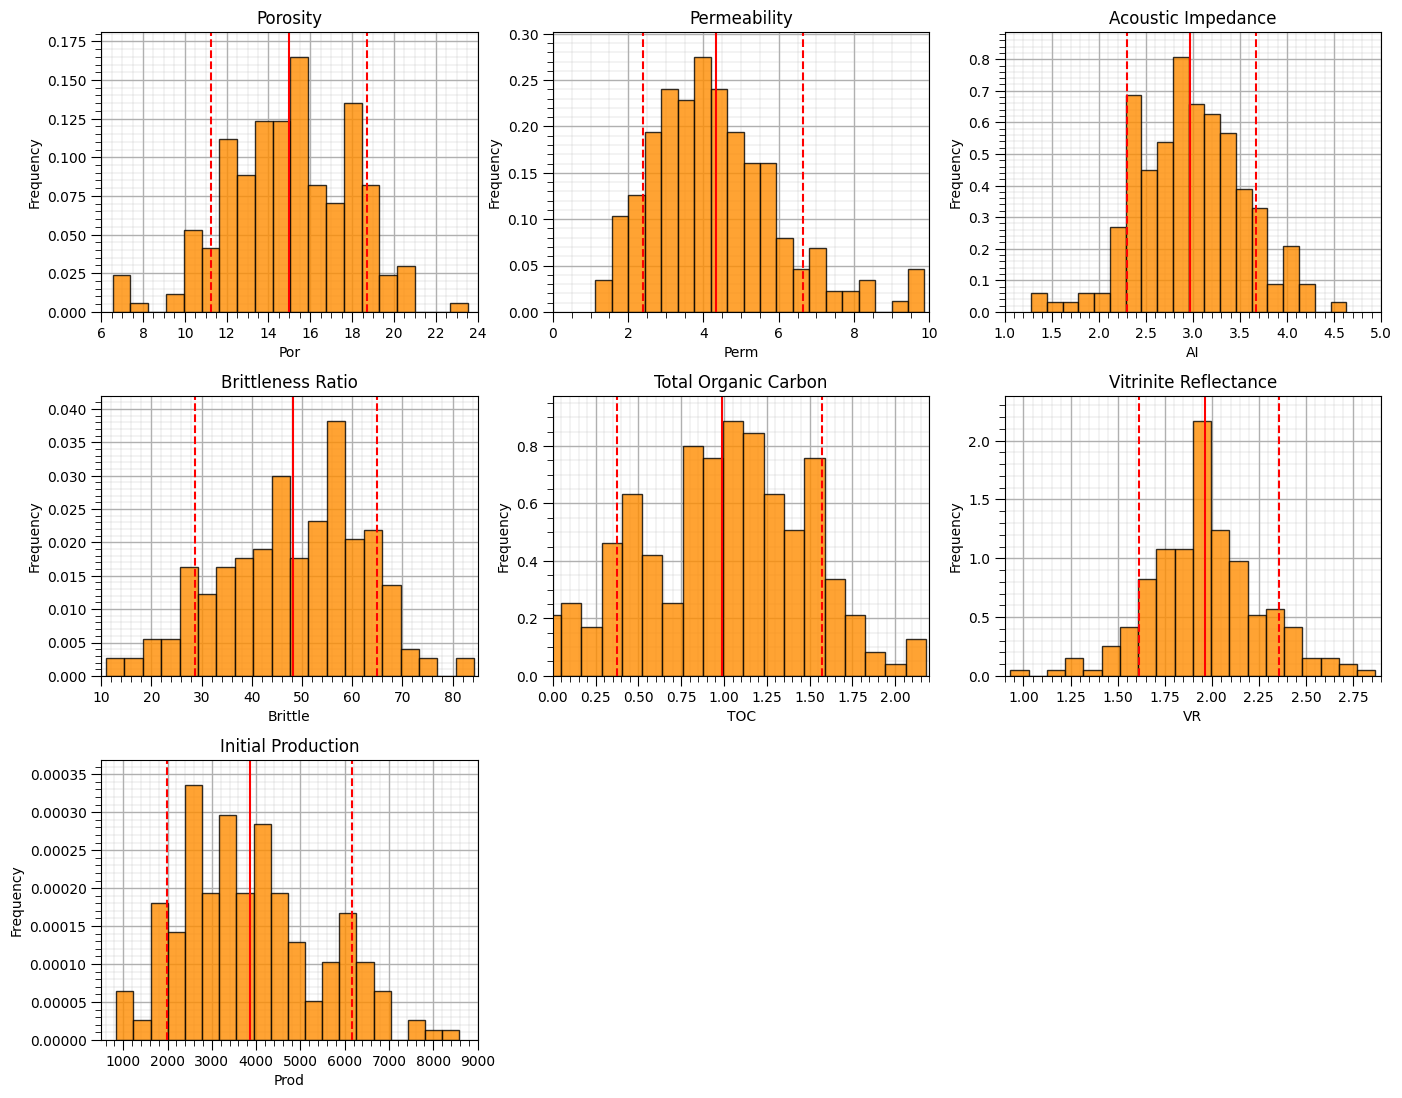

In [8]:
nbins = 20                                                    # number of histogram bins
for i, feature in enumerate(features):                        # plot histograms with central tendancy and P10 and P90 labelled
    plt.subplot(3,3,i+1)
    y,_,_ = plt.hist(x=df[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True)
    histogram_bounds(values=df[feature].values,weights=np.ones(len(df)),color='red')
    plt.xlabel(feature); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); plt.title(featuretitle[i]); add_grid() 
    if feature == resp:   
        plt.xlim([Ymin,Ymax])    
    else:
        plt.xlim([xmin[i],xmax[i]]) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.3); plt.show()

There are just a couple slighly negative values, let's just truncate them at zero. We   can use this command below to set all TOC values in the DataFrame that are less than 0.0 as 0.0, otherwise we keep the original TOC value.

### Feature Transformations

Now let's step through, describe, demonstrate and visualize each feature transformation.

#### Truncation

It is possible that the features may extend beyond the plausible range of values.

* truncation is simply assigning values outside the range with a specific value

* it is common to assign the minimum permissible value to outliers on the lower tail and visa versa

Truncation can be handled easily with numpy operators applied to the feature array within the Pandas DataFrame

```python
num = df._get_numeric_data() 
num[num < data_min] = data_min
num[num > data_max] = data_max
```

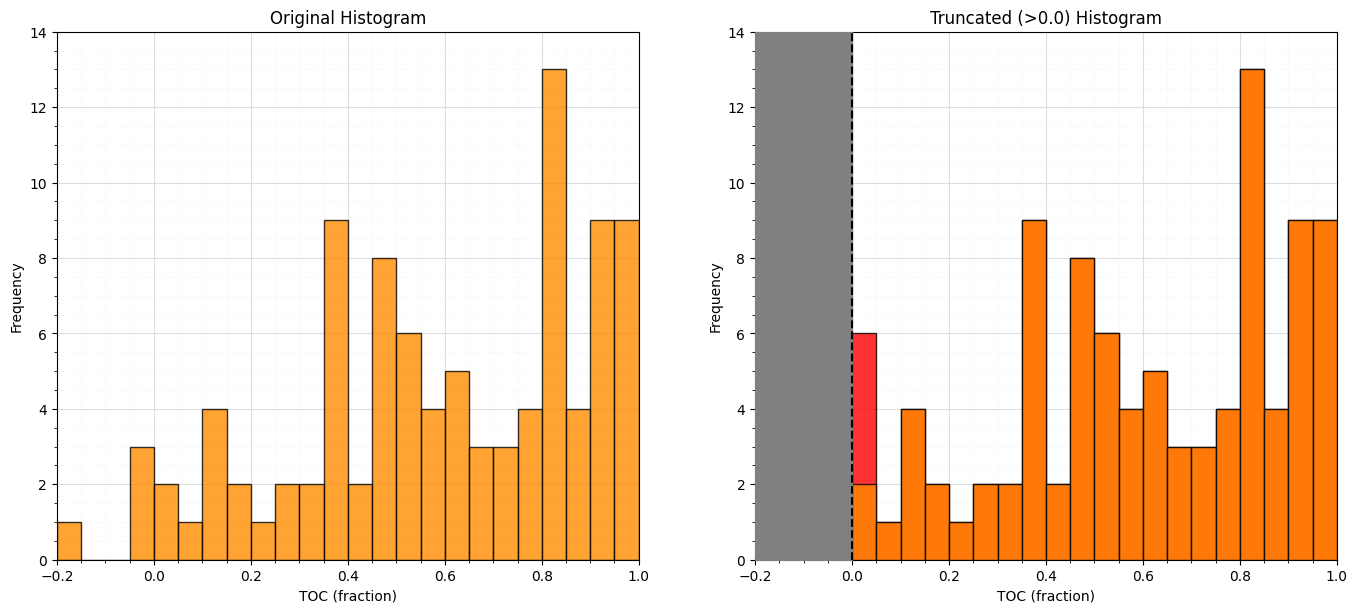

In [9]:
plt.subplot(121)
plt.hist(df['TOC'].values,color='darkorange',alpha=0.8,edgecolor='black',bins=np.linspace(-0.2,1.0,25))
plt.xlabel('TOC (fraction)'); plt.ylabel('Frequency'); plt.title('Original Histogram'); plt.ylim([0,14]); plt.xlim([-0.2,1.0])
plt.gca().grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.gca().grid(which='major', color='#DDDDDD', linewidth=0.8); plt.gca().minorticks_on()

old_TOC = df['TOC'].values.copy()
num = df._get_numeric_data()                                  # get the numerical values
num[num < 0] = 0                                              # truncate negative values to 0.0
df.describe().transpose()                                     # get the summary statistics of all features

plt.subplot(122)
plt.hist(df['TOC'].values,color='red',alpha=0.8,edgecolor='black',bins=np.linspace(-0.2,1.0,25),zorder=10)
plt.hist(old_TOC,color='darkorange',alpha=0.8,edgecolor='black',bins=np.linspace(-0.2,1.0,25),zorder=20)
plt.xlabel('TOC (fraction)'); plt.ylabel('Frequency'); plt.title('Truncated (>0.0) Histogram'); plt.ylim([0,14]); plt.xlim([-0.2,1.0])
plt.fill_between([-0.2,0.0],[14,14],[0,0],color='grey',alpha=1.0,zorder=30); plt.plot([0.0,0.0],[0,14],color='black',ls='--',zorder=30)
plt.gca().grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.gca().grid(which='major', color='#DDDDDD', linewidth=0.8); plt.gca().minorticks_on()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Let's look at the summary statistics again to confirm that we were successful in truncating TOC to $\ge 0$.

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


From the summary statistics you can see that the truncation was successful, we now have a minimum of 0.0.

#### Affine Correction

The affine correction is the transform of the feature distribution to a new mean and variance.

* this is a shift and stretch / squeeze of the original property distribution

* no shape change is assumed

The following equation is applied to each sample in the original distribution

$$
y = \frac{\sigma_y}{\sigma_x}\left( x - \overline{x} \right) + \overline{y}
$$

where $\sigma_x$ is the original standard deviation, $\sigma_y$ is the target standard deviation, $\overline{x}$ is the original mean and $\overline{y}$ is the target mean.

* there is an affine function in GeostatsPy that we may use

* for brevity we will just transform a single feature, note the function is not set up to transfrom more than one feature at a time, nor does the function handle the back transformation.

Let's transform porosity to have an arbitrary mean and standard deviation ($\overline{x} = 20\%$ and $\sigma_x = 3\%$)

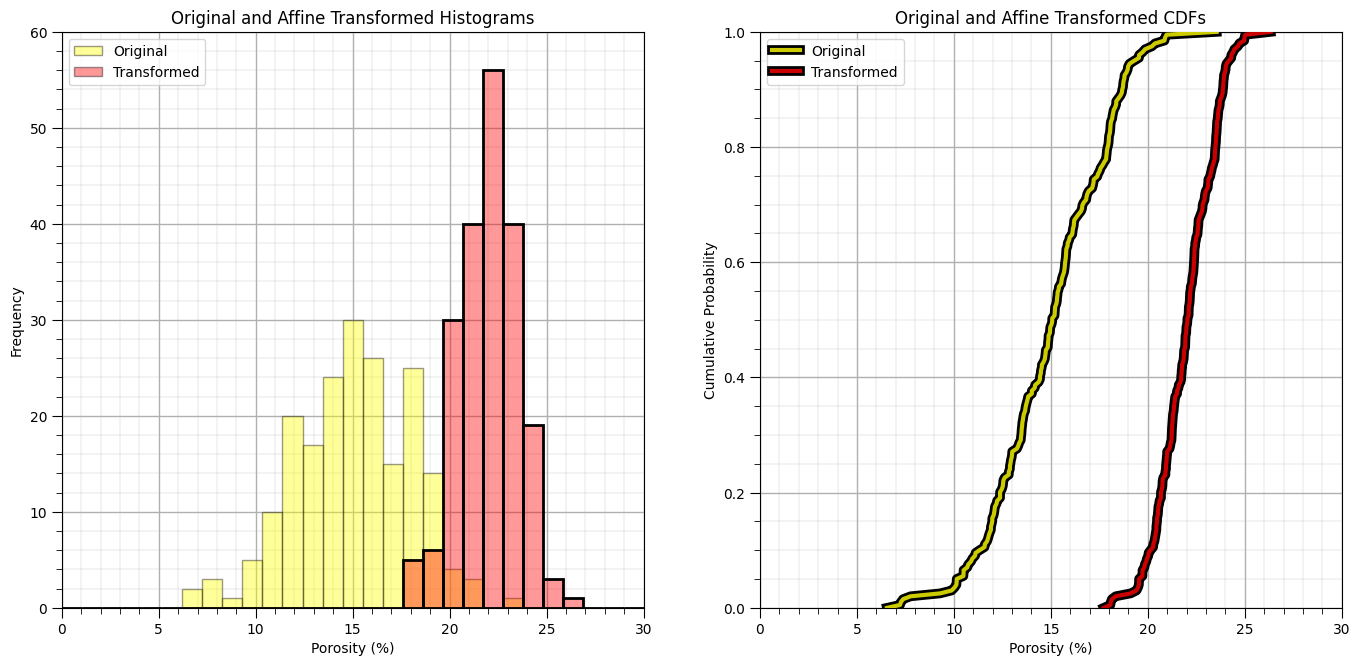

In [11]:
df['aPor'] = GSLIB.affine(df['Por'].values,tmean = 22.0,tstdev = 1.5) # affine correction

plt.subplot(121)
plt.hist(df['Por'].values,color='yellow',alpha=0.4,edgecolor='black',bins=np.linspace(0.0,30.0,30),label='Original')
plt.hist(df['aPor'].values,color='red',alpha=0.4,edgecolor='black',bins=np.linspace(0.0,30.0,30),label='Transformed')
plt.hist(df['aPor'].values,fill=False,alpha=1.0,edgecolor='black',lw=2.0,bins=np.linspace(0.0,30.0,30))
plt.legend(loc='upper left'); plt.grid(True)
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Original and Affine Transformed Histograms'); plt.ylim([0,60]); plt.xlim([0.0,30.0])
add_grid()

plt.subplot(122)
plt.plot(np.sort(df['Por']),np.linspace(0,1,len(df)),color='yellow',alpha=0.8,lw=3,zorder=10,label='Original', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.plot(np.sort(df['aPor']),np.linspace(0,1,len(df)),color='red',alpha=0.8,lw=3,zorder=10,label='Transformed', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.xlim([0,30]); plt.ylim(0,1); plt.xlabel('Porosity (%)'); plt.ylabel('Cumulative Probability'); 
plt.title('Original and Affine Transformed CDFs'); plt.legend(loc='upper left'); plt.grid(True)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Let's check the summary statistics of our new feature.

In [12]:
df['aPor'].describe().transpose()

count    200.000000
mean      22.000000
std        1.503764
min       17.727787
25%       20.947959
50%       22.039907
75%       23.220426
max       26.331783
Name: aPor, dtype: float64

Let's remove the affine transformed feature.

In [13]:
df = df.drop(columns = ['aPor'])

#### Standardization

Standardization is the transform of the feature distribution to a mean of zero and a variance of one.

* this is a shift and stretch / squeeze of the original property distribution

* no shape change is assumed

The transform is effectively a specific case of the affine correction, with $\overline{y} = 0$ and $\sigma_y = 1.0$.

\begin{equation}
y = \frac{1}{\sigma_x}\left( x - \overline{x} \right)
\end{equation}

where $\sigma_x$ is the original standard deviation and $\overline{x}$ is the original mean.

Let's standardize the feature to have:

* mean = 0.0
* variance = standard deviation = 1.0

To do this we:

1. instantiate the StandardScaler from scikit learn. We assign it as 'scaler' so we can use it to conveniently reverse the transformation if we like. We will need to do that to get our predictions back into regular production units.

```python
scaler = StandardScaler()
```

2. we then extract all the values from our DataFrame and apply the by-column standardization.  The result is a 2D ndarray

```python
sfeatures = scaler.fit_transform(df_mv.values)
```
3. we make an new empty DataFrame

```python
df_nmv = pd.DataFrame()
```

4. then we add the transformed value to the new DataFrame while keeping the sample index and feature names from the old DataFramae

```python
df_nmv = pd.DataFrame(sfeatures, index=df_mv.index, columns=df_mv.columns)
```

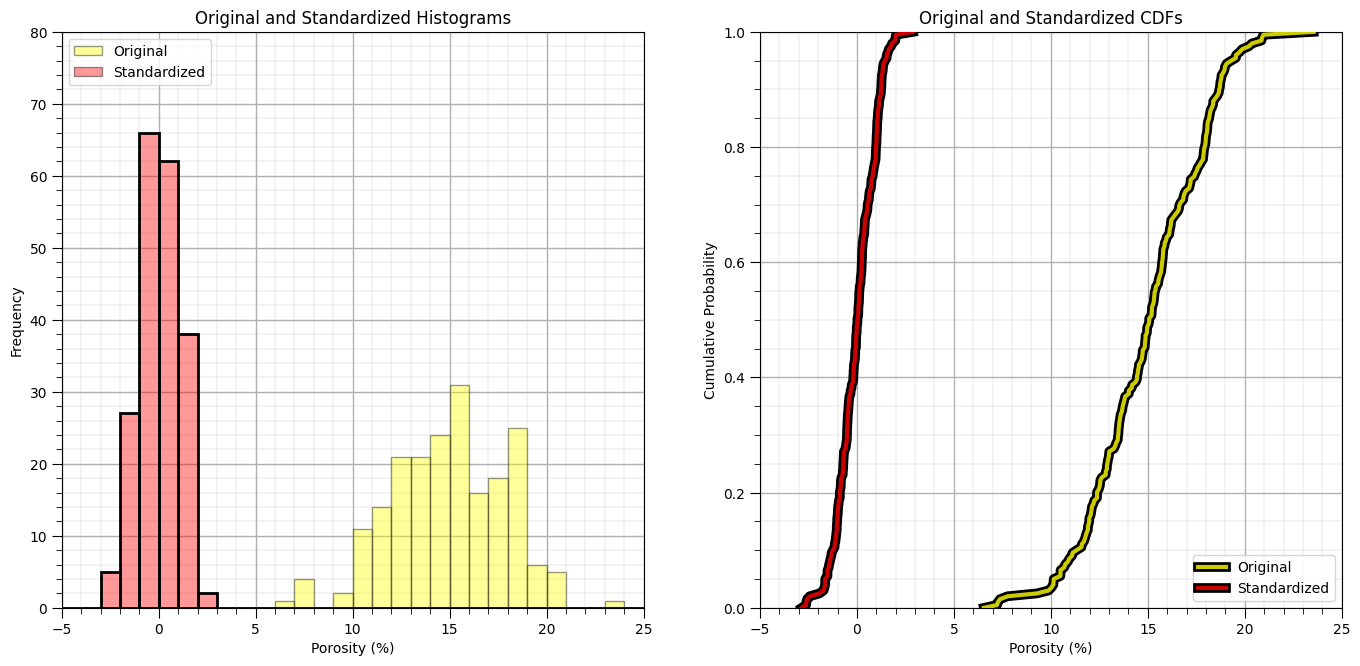

In [14]:
scaler = StandardScaler()                                     # instantiate the scaler 
sfeatures = scaler.fit_transform(df.values)                   # standardize all the values extracted from the DataFrame 
df_st = pd.DataFrame()                                        # instantiate a new DataFrame
df_st = pd.DataFrame(sfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame

plt.subplot(121)
plt.hist(df['Por'].values,color='yellow',alpha=0.4,edgecolor='black',bins=np.linspace(-5.0,30.0,36),label='Original')
plt.hist(df_st['Por'].values,color='red',alpha=0.4,edgecolor='black',bins=np.linspace(-5.0,30.0,36),label='Standardized')
plt.hist(df_st['Por'].values,fill=False,alpha=1.0,edgecolor='black',lw=2.0,bins=np.linspace(-5.0,30.0,36))
plt.legend(loc='upper left')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Original and Standardized Histograms'); plt.ylim([0,80]); plt.xlim([-5.0,25.0])
add_grid()

plt.subplot(122)
plt.plot(np.sort(df['Por']),np.linspace(0,1,len(df)),color='yellow',alpha=0.8,lw=3,zorder=10,label='Original', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.plot(np.sort(df_st['Por']),np.linspace(0,1,len(df)),color='red',alpha=0.8,lw=3,zorder=10,label='Standardized', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.xlim([-5,25]); plt.ylim(0,1); plt.xlabel('Porosity (%)'); plt.ylabel('Cumulative Probability'); 
plt.title('Original and Standardized CDFs'); plt.legend(loc='lower right'); plt.grid(True)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Let's close the loop and reverse the transformation and confirm that we get back to the original data.

To do this we:

5. call the 'fit' features' scaler's inverse transform function transformed value to the new DataFrame while keeping the sample index and feature names from the old DataFramae

```python
rfeatures = scaler.inverse_transform(df_st.values)
```

the output from this is a 2D numpy array. 

6. We will put it into a new DataFrame.

```python
df_reverse = pd.DataFrame(rfeatures, index=df.index, columns=df.columns)
```

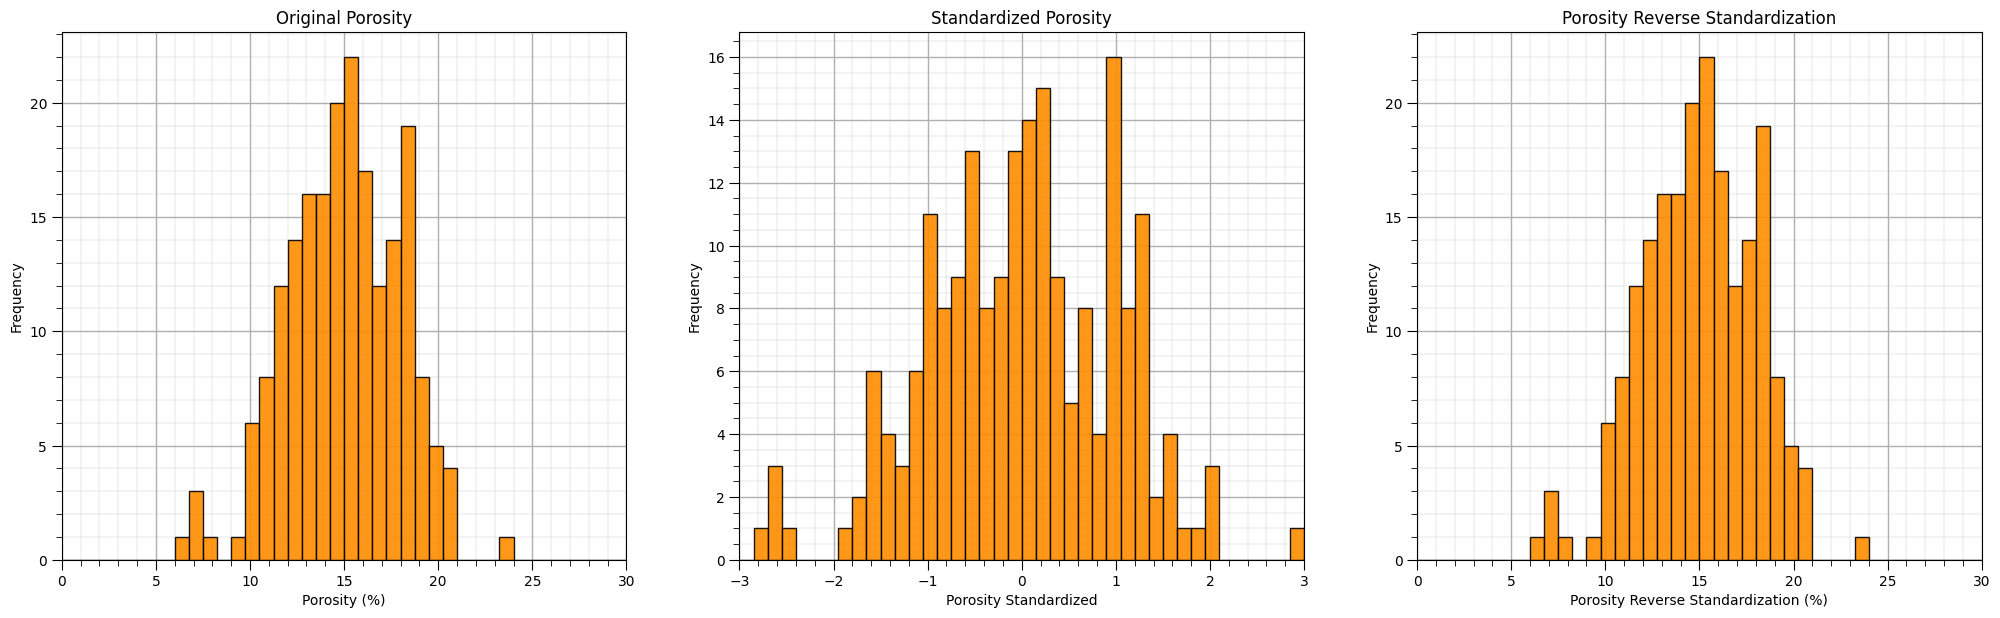

In [15]:
rfeatures = scaler.inverse_transform(df_st.values)
df_reverse = pd.DataFrame(rfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame
df_reverse.head() 

plt.subplot(131)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
add_grid()

plt.subplot(132)
GSLIB.hist_st(df_st['Por'].values,-3,3,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Standardized',title='Standardized Porosity')
add_grid()

plt.subplot(133)
GSLIB.hist_st(df_reverse['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Reverse Standardization (%)',title='Porosity Reverse Standardization')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)

You can confirm the result is the same as the original, prior to standardization DatatFrame.

We were just testing, so let's get rid of (delete) the new DataFrame.  We can use the following to delete an instantiated object in Python.

```python
del df_reverse
```

For more complicated workflows it may be a good idea to remove intermediate products to save memmory and to prevent clutter!

In [16]:
del df_reverse

### Normalization

Also known as the min / max transform, recales the features to have a minimum of 0 and a maximum of 1.

$$
y = \frac{x - min(x)}{max(x) - min(x)}
$$

where $min(x)$ and $max(x)$ are the minimum and maximum values for each feature.

* scikit learn has a built in min / max transform method

```python
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
```

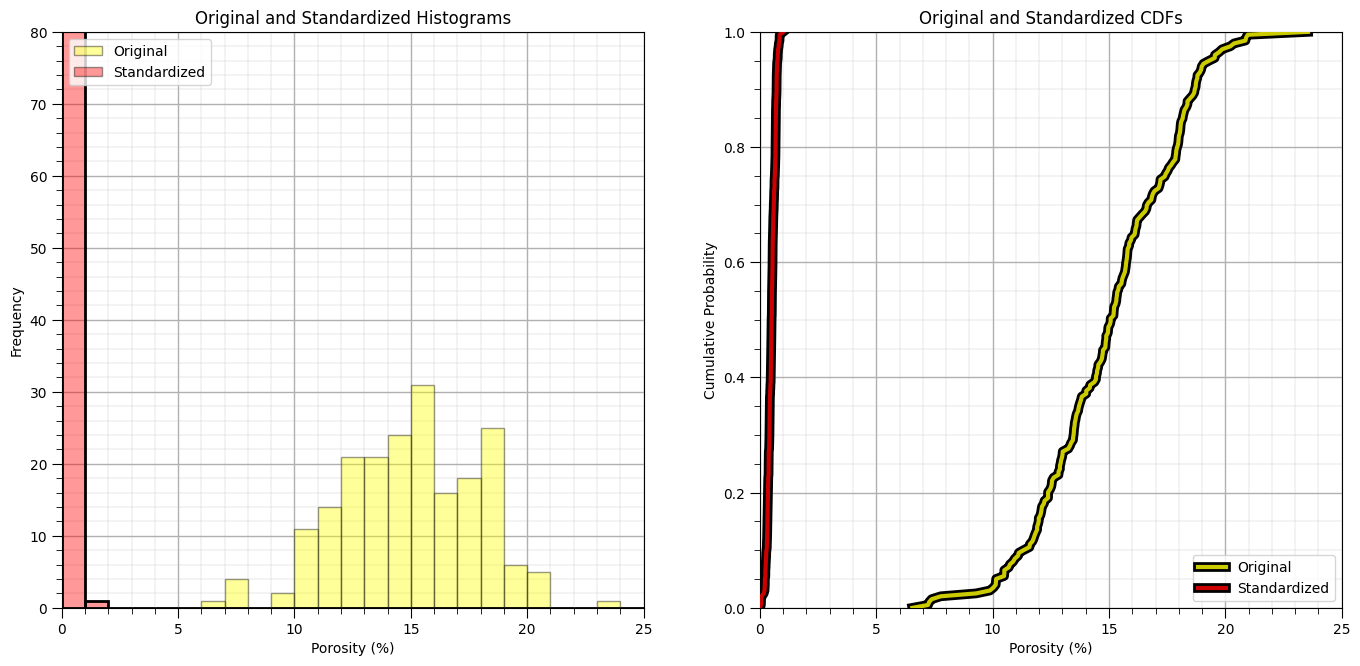

In [17]:
norm_scaler = preprocessing.MinMaxScaler()                 # instantiate the scaler 
nfeatures = norm_scaler.fit_transform(df.values)           # standardize all the values extracted from the DataFrame 
df_n = pd.DataFrame(nfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame
df_n.head() 

plt.subplot(121)
plt.hist(df['Por'].values,color='yellow',alpha=0.4,edgecolor='black',bins=np.linspace(0.0,25.0,26),label='Original')
plt.hist(df_n['Por'].values,color='red',alpha=0.4,edgecolor='black',bins=np.linspace(0.0,25.0,26),label='Standardized')
plt.hist(df_n['Por'].values,fill=False,alpha=1.0,edgecolor='black',lw=2.0,bins=np.linspace(0.0,25.0,26))
plt.legend(loc='upper left')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Original and Standardized Histograms'); plt.ylim([0,80]); plt.xlim([0.0,25.0])
add_grid()

plt.subplot(122)
plt.plot(np.sort(df['Por']),np.linspace(0,1,len(df)),color='yellow',alpha=0.8,lw=3,zorder=10,label='Original', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.plot(np.sort(df_n['Por']),np.linspace(0,1,len(df)),color='red',alpha=0.8,lw=3,zorder=10,label='Standardized', path_effects=[pe.Stroke(linewidth=7, foreground='black'), pe.Normal()])
plt.xlim([0,25]); plt.ylim(0,1); plt.xlabel('Porosity (%)'); plt.ylabel('Cumulative Probability'); 
plt.title('Original and Standardized CDFs'); plt.legend(loc='lower right'); plt.grid(True)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Let's check the summary statistics.

In [18]:
df_n.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,200.0,0.496538,0.174775,0.0,0.374265,0.501176,0.638382,1.0
Perm,200.0,0.366219,0.198057,0.0,0.227975,0.332380,0.475686,1.0
AI,200.0,0.504134,0.169220,0.0,0.378358,0.500000,0.616418,1.0
Brittle,200.0,0.507180,0.192526,0.0,0.365377,0.525548,0.644809,1.0
TOC,200.0,0.455023,0.219387,0.0,0.283257,0.472477,0.619266,1.0
VR,200.0,0.533144,0.155066,0.0,0.432990,0.530928,0.625000,1.0
Prod,200.0,0.390241,0.200408,0.0,0.238229,0.356681,0.504843,1.0


Let's close the loop and reverse the transformation (back-transform) and confirm that we get back to the original data.

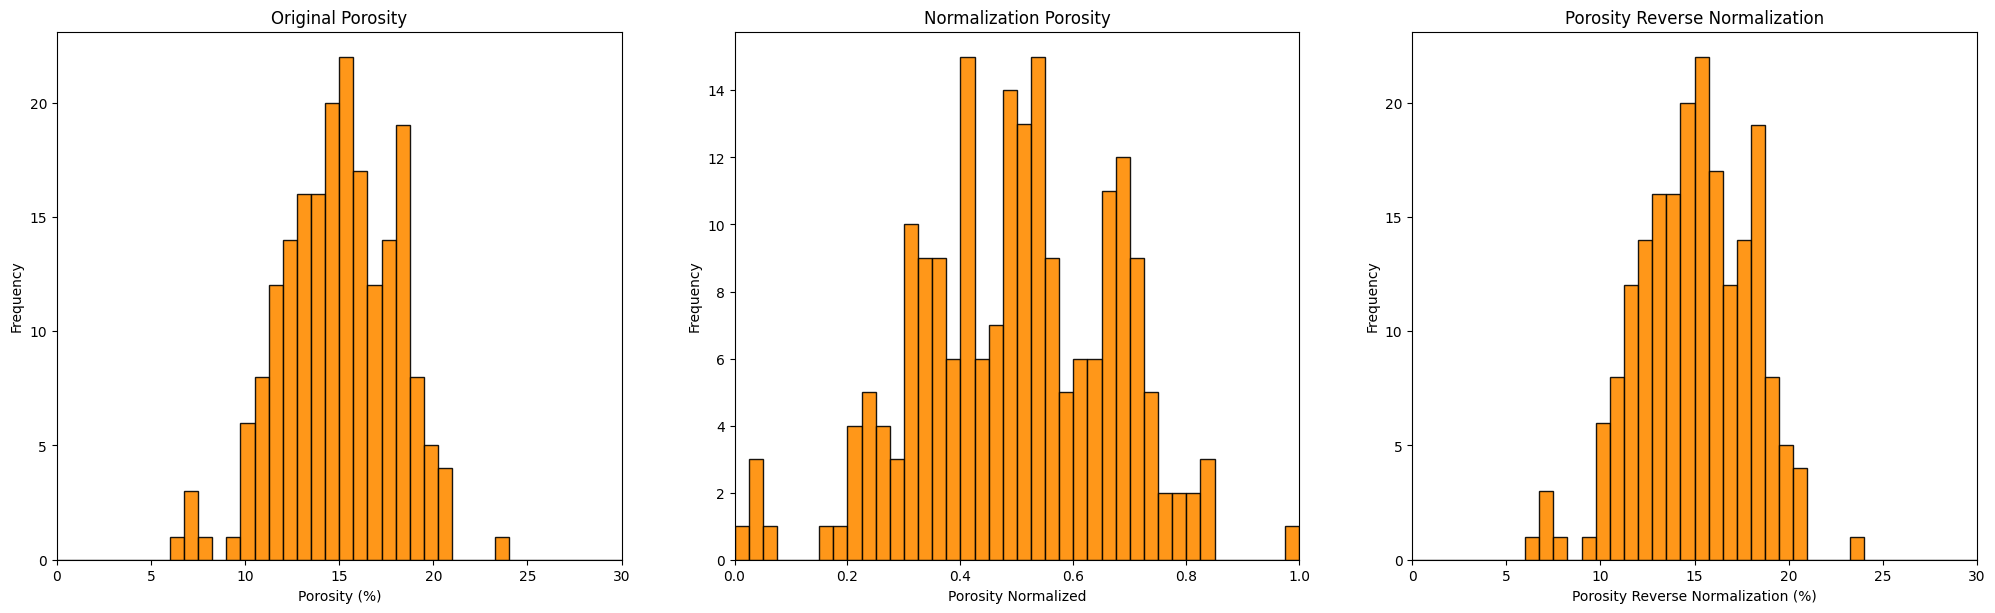

In [19]:
rfeatures = norm_scaler.inverse_transform(df_n.values)
df_reverse = pd.DataFrame()                                     # instantiate a new DataFrame
df_reverse = pd.DataFrame(rfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame
df_reverse.head() 

plt.subplot(131)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)

plt.subplot(132)
GSLIB.hist_st(df_n['Por'].values,0,1,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Normalized',title='Normalization Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)

plt.subplot(133)
GSLIB.hist_st(df_reverse['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Reverse Normalization (%)',title='Porosity Reverse Normalization')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

You can confirm the result is the same as the original, prior to standardization DataFrame.

Once again we were just testing, so let's delete the back-transformed DataFrame.

In [20]:
del df_reverse

#### L1 / L2 Normalizer

Another type of normalization is performed independently on each sample to force the $L1$ or $L2$ norm to be 1.0.

For the L1 norm:

$$
\sum^m_{i,\alpha = 1} x_{i, \alpha} = 1.0, \quad i = 1, \ldots, n
$$

where we have $x_{i, \alpha}, \alpha = 1, \dots, m$ features over $i = 1, \dots, n$ samples.

For the L2 norm:

$$
\sum^m_{i,\alpha = 1}\left( x_{i, \alpha} \right)^2 = 1.0, \quad i = 1, \ldots, n
$$

where we have $x_{i, \alpha}, \alpha = 1, \dots, m$ features over $i = 1, \dots, n$ samples.

* this may be applied in text classification or clustering

We demonstrate the L1 and L2 normalizer below.

* there is no reverse to this transform

Let's start with the $L2$ norm.

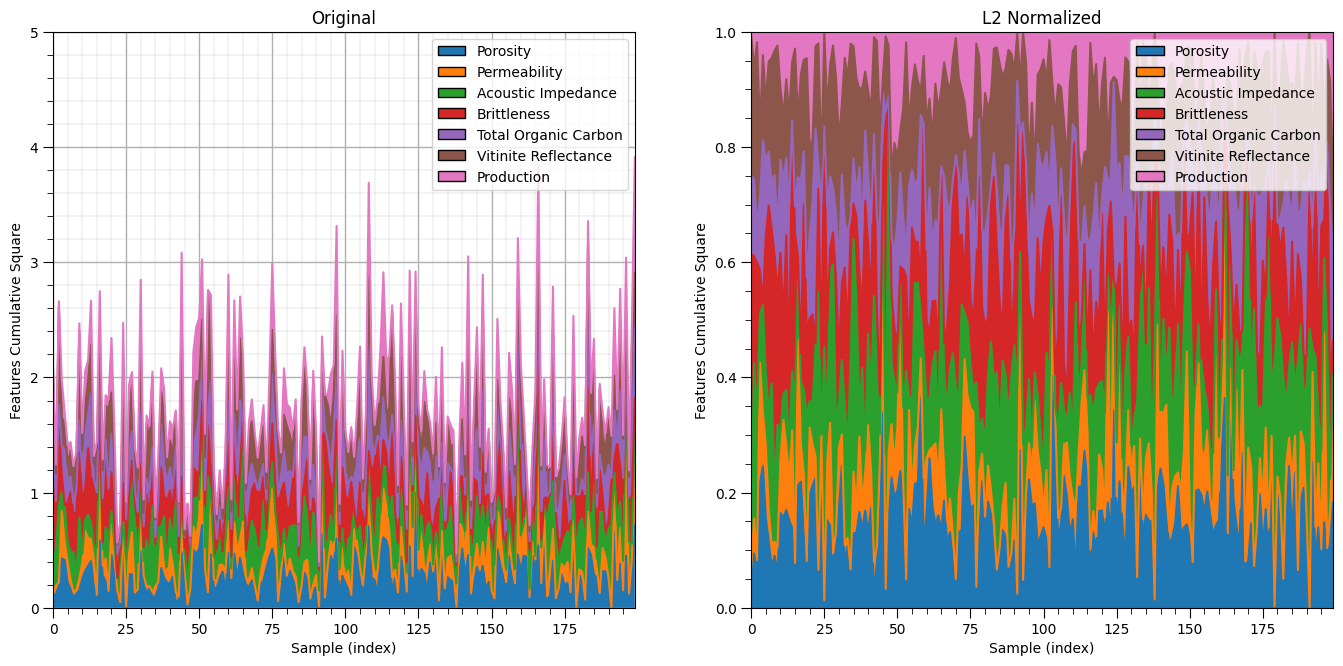

In [21]:
l2normalizer = Normalizer(norm = 'l2') 
l2features = l2normalizer.fit_transform(df_n) 

colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22', '#17becf']
names = ['Porosity','Permeability','Acoustic Impedance','Brittleness','Total Organic Carbon','Vitinite Reflectance','Production']

plt.subplot(121)
n_cumul_sum =np.cumsum(np.power(df_n.values,2),axis=1)
for i in range(0,l2features.shape[1]):
    plt.plot(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i])
    
plt.fill_between(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i],np.zeros(len(df)))
for i in range(1,l2features.shape[1]):
    plt.fill_between(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i],n_cumul_sum[:,i-1])
 
plt.xlim([0,len(df)-1]); plt.ylim([0,5])
plt.xlabel('Sample (index)'); plt.ylabel('Features Cumulative Square'); plt.title('Original')

legend_elements = []
for i in range(len(names)):
    legend_elements.append(Patch(facecolor=colors[i], edgecolor='black',label=names[i]))
plt.gca().legend(handles=legend_elements, loc='upper right')
add_grid()

plt.subplot(122)
l2_cumul_sum =np.cumsum(np.power(l2features,2),axis=1)
for i in range(0,l2features.shape[1]):
    plt.plot(np.linspace(0,len(df)-1,len(df)),l2_cumul_sum[:,i])
    
plt.fill_between(np.linspace(0,len(df)-1,len(df)),l2_cumul_sum[:,i],np.zeros(len(df)))
for i in range(1,l2features.shape[1]):
    plt.fill_between(np.linspace(0,len(df)-1,len(df)),l2_cumul_sum[:,i],l2_cumul_sum[:,i-1])

plt.xlim([0,len(df)-1]); plt.ylim([0,1])
plt.xlabel('Sample (index)'); plt.ylabel('Features Cumulative Square'); plt.title('L2 Normalized')

legend_elements = []
for i in range(len(names)):
    legend_elements.append(Patch(facecolor=colors[i], edgecolor='black',label=names[i]))
plt.gca().legend(handles=legend_elements, loc='upper right')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Now let's demonstrate the $L1$ norm.

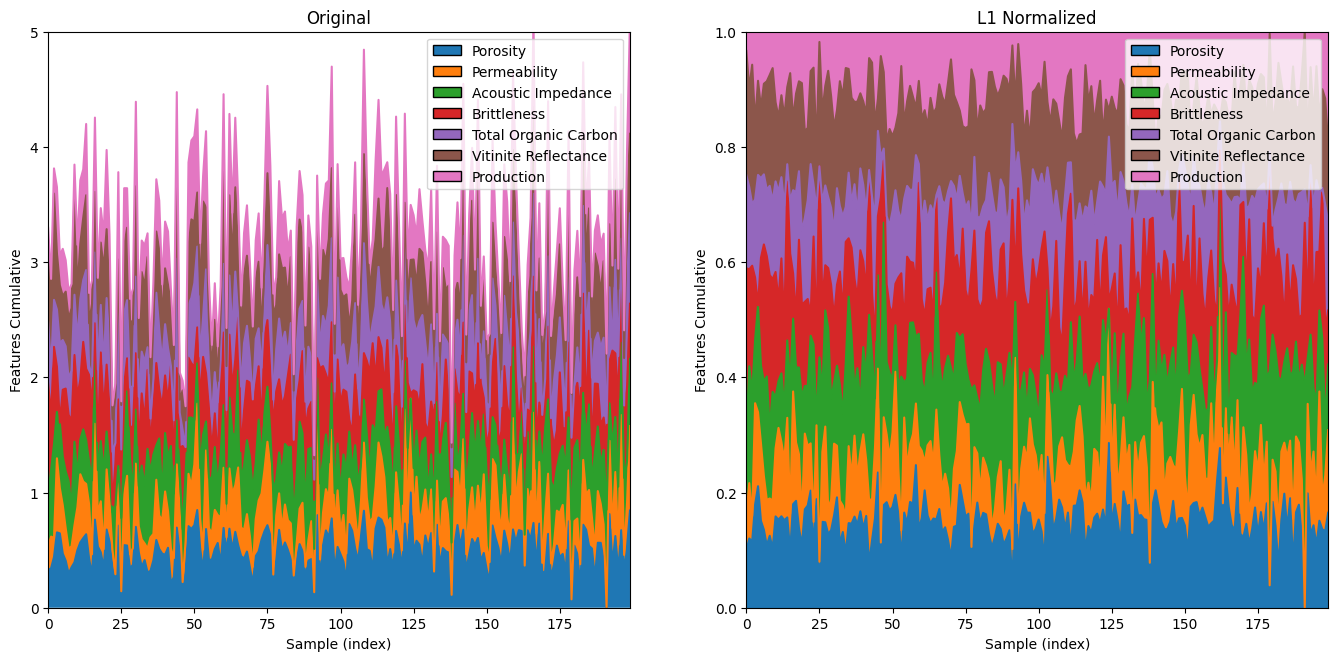

In [22]:
l1normalizer = Normalizer(norm = 'l1') 
l1features = l1normalizer.fit_transform(df_n)                                                             # standardize all the values extracted from the DataFrame 
df_nL1 = pd.DataFrame()                                      # instantiate a new DataFrame
df_nL1 = pd.DataFrame(l1features, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame
df_nL1.head() 

colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22', '#17becf']
names = ['Porosity','Permeability','Acoustic Impedance','Brittleness','Total Organic Carbon','Vitinite Reflectance','Production']

plt.subplot(121)
n_cumul_sum =np.cumsum(df_n.values,axis=1)
for i in range(0,l1features.shape[1]):
    plt.plot(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i])
    
plt.fill_between(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i],np.zeros(len(df)))
for i in range(1,l1features.shape[1]):
    plt.fill_between(np.linspace(0,len(df)-1,len(df)),n_cumul_sum[:,i],n_cumul_sum[:,i-1])

plt.xlim([0,len(df)-1]); plt.ylim([0,5])
plt.xlabel('Sample (index)'); plt.ylabel('Features Cumulative'); plt.title('Original')

legend_elements = []
for i in range(len(names)):
    legend_elements.append(Patch(facecolor=colors[i], edgecolor='black',label=names[i]))
plt.gca().legend(handles=legend_elements, loc='upper right')

plt.subplot(122)
l1_cumul_sum =np.cumsum(l1features,axis=1)
for i in range(0,l1features.shape[1]):
    plt.plot(np.linspace(0,len(df)-1,len(df)),l1_cumul_sum[:,i])
    
plt.fill_between(np.linspace(0,len(df)-1,len(df)),l1_cumul_sum[:,i],np.zeros(len(df)))
for i in range(1,l1features.shape[1]):
    plt.fill_between(np.linspace(0,len(df)-1,len(df)),l1_cumul_sum[:,i],l1_cumul_sum[:,i-1])

plt.xlim([0,len(df)-1]); plt.ylim([0,1])
plt.xlabel('Sample (index)'); plt.ylabel('Features Cumulative'); plt.title('L1 Normalized')

legend_elements = []
for i in range(len(names)):
    legend_elements.append(Patch(facecolor=colors[i], edgecolor='black',label=names[i]))
plt.gca().legend(handles=legend_elements, loc='upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Binary or Indictor Transform

For the many problems that we need to perform a binary transform to convert our continuous feature to 0's and 1's based on a threshold, $x_t$

* for the binary transform, $x_i = 0$ if $<= x_t$ and $x_i = 1$ otherwise
* for the indicator transform, $x_i = 1$ if $<= x_t$ and $x_i = 0$ otherwise

There is a scikit-learn function for the binary transform

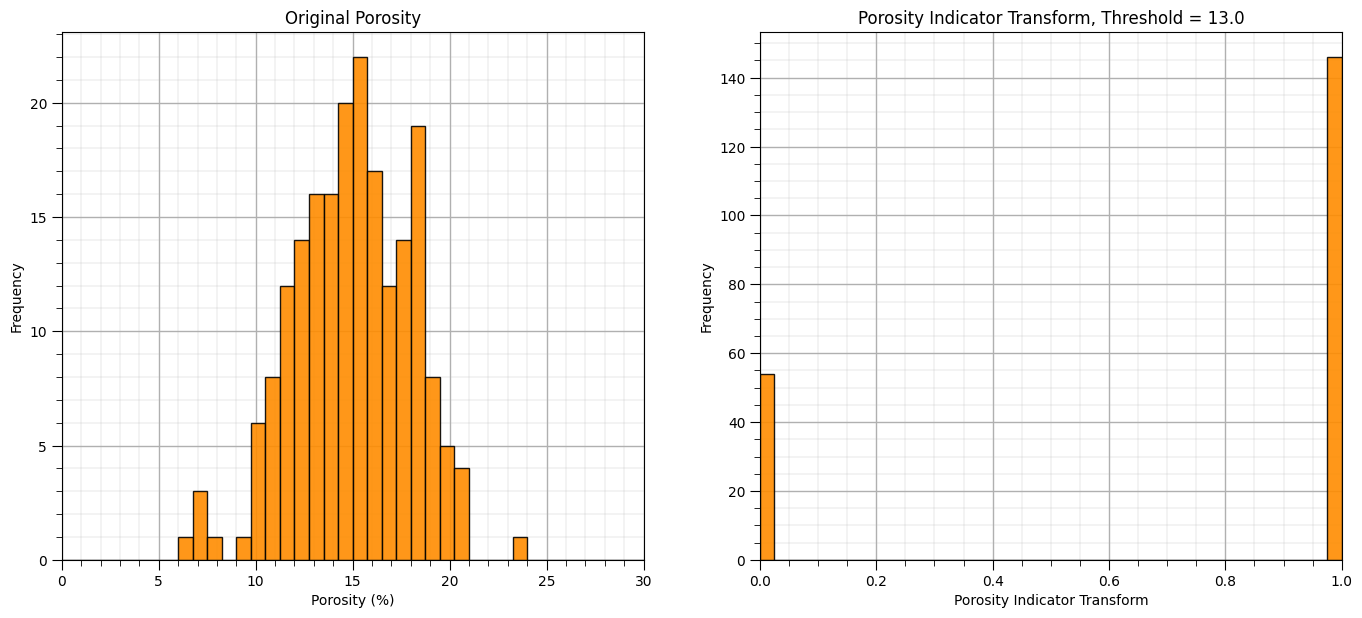

In [23]:
threshold = 13.0
binarizer = Binarizer(threshold = threshold) 
bPor = binarizer.fit_transform(df['Por'].values.reshape(-1, 1))                                                         # standardize all the values extracted from the DataFrame 

plt.subplot(121)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
add_grid()

plt.subplot(122)
GSLIB.hist_st(bPor,0,1,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Indicator Transform',title='Porosity Indicator Transform, Threshold = ' + str(threshold))
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)

#### k Bins Discretization

With k bins discretization we bin the range of the feature into K bins and then expand each sample for our continuous feature to K features with the assignment of a value of 1 if the sample is within a bin and 0 if outsize the bin

* strategies include uniform width bins (uniform) and uniform number of data in each bin (quantile)

Let's make 5 uniform bins and then concatenate the original porosity values so we can compare the original porosity values and our K bins discretization.

In [24]:
nbins = 5
kbins = KBinsDiscretizer(n_bins=nbins, strategy='uniform',encode='onehot') 
kbins_por = kbins.fit_transform(df['Por'].values.reshape(-1, 1))                                                         # standardize all the values extracted from the DataFrame 
kbins_values = np.concatenate((df['Por'].values.reshape(-1, 1),kbins_por.toarray()),axis=1)
kbins_values

array([[12.08,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [12.38,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [14.02,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       ...,
       [12.12,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [15.55,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [20.89,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

Visualize k bins discritization.

* Let's look at original data distribution and the bin boundaries to better understand the result above.

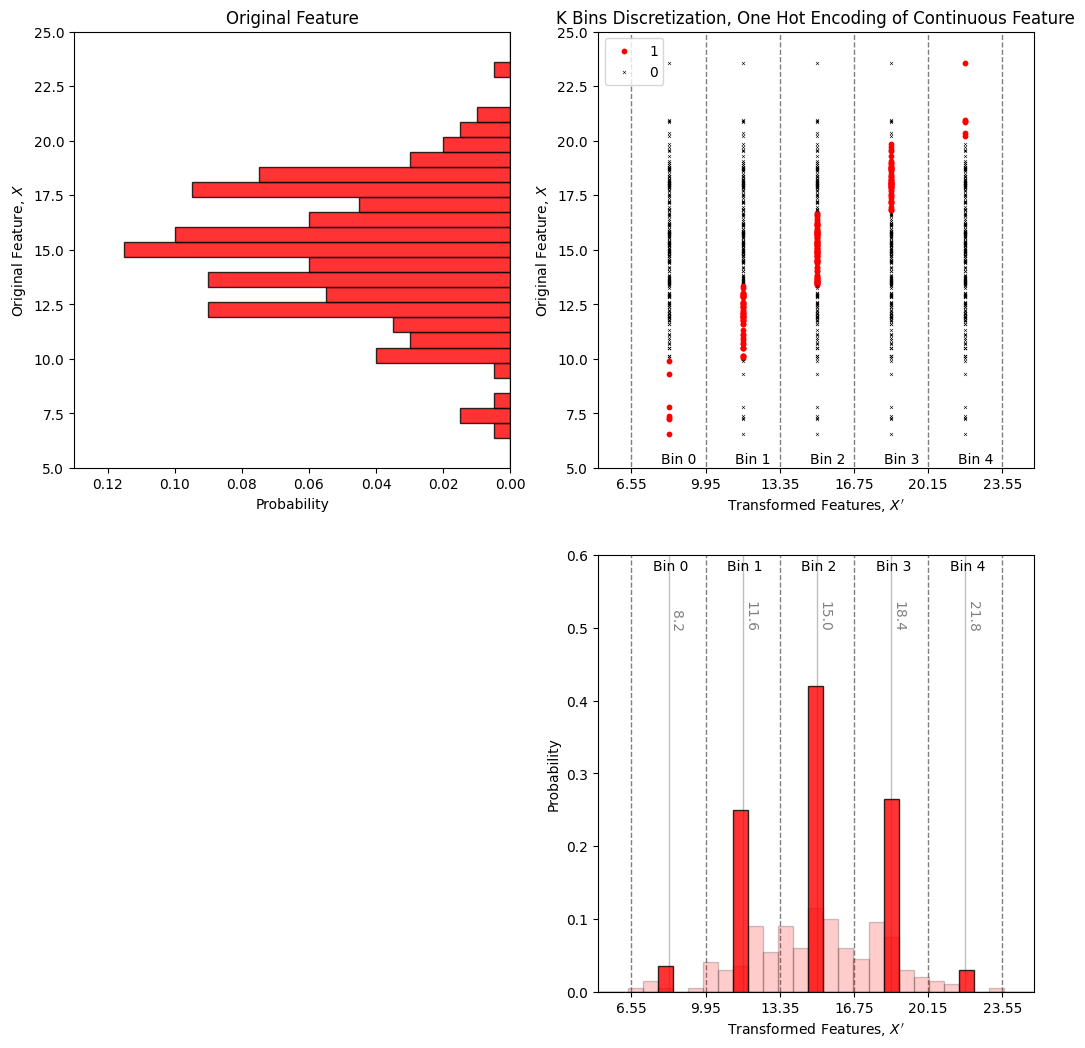

In [25]:
kbins_edges = kbins.bin_edges_[0]
kbins_centers = (kbins_edges[1:] + kbins_edges[:-1]) / 2
bsiz = (np.max(kbins_edges) - np.min(kbins_edges))/nbins
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2,2 ,width_ratios=(1.0, 1.0))

plt_scatter = fig.add_subplot(gs[0, 1])
plt_x = fig.add_subplot(gs[0, 0],sharey=plt_scatter) 
plt_y = fig.add_subplot(gs[1, 1],sharex=plt_scatter) 

for i in range(0,len(df)):
    ones = kbins_centers[kbins_values[i][1:] == 1.0]
    plt_scatter.scatter(ones,np.full(len(ones),kbins_values[i][0]),marker = 'o',s=10,color='red')
    zeros = kbins_centers[kbins_values[i][1:] == 0.0]
    plt_scatter.scatter(zeros,np.full(len(zeros),kbins_values[i][0]),color='black',s=5,marker='x',lw=0.4)
    #print(zeros,np.full(len(zeros),kbins_values[i][0]))

for edge in kbins_edges:
    plt_scatter.plot([edge,edge],[0,30],color='black',lw=1,ls='--',alpha=0.5)
    #plt.plot([5,25],[edge,edge],color='black',lw=1,ls='--',alpha=0.5)
    
for icenter,center in enumerate(kbins_centers):
    plt_scatter.annotate('Bin ' + str(icenter),[center-bsiz*0.1,5.2])
    
plt_scatter.set_ylabel(r'Original Feature, $X$'); plt_scatter.set_xlabel(r'Transformed Features, $X^{\prime}$')
plt_scatter.set_xlim([5,25]); plt_scatter.set_ylim([5,25])

plt_scatter.scatter(-9999.9,99999,marker = 'o',s=10,color='red',label='1')
plt_scatter.scatter(-9999.9,99999,color='black',s=5,marker='x',lw=0.4,label='0')
plt_scatter.set_xticks(kbins_edges)
plt_scatter.legend(loc='upper left')
plt_scatter.set_title('K Bins Discretization, One Hot Encoding of Continuous Feature')
    
plt_x.hist(df['Por'].values,orientation='horizontal',density = False,weights = np.ones(len(df))/len(df),
           color='red',alpha=0.8,edgecolor='black',bins=np.linspace(5.0,25.0,30))
#for edge in kbins_edges:
    #plt_scatter.plot([edge,edge],[0,30],color='black',lw=1,ls='--',alpha=0.5)
    #plt_x.plot([.2,0],[edge,edge],color='black',lw=1,ls='--',alpha=0.5)

plt_x.set_xlim([0.13,0.0])
plt_x.set_ylabel(r'Original Feature, $X$'); plt_x.set_xlabel(r'Probability') 
plt_x.set_title('Original Feature')

z_values = np.zeros(int(np.sum(kbins_values[:,1:])))
count = np.sum(kbins_values[:,1:],axis=0)
ii = 0
for i in range(0,kbins_values[:,1:].shape[1]):
    for j in range(0,int(count[i])):
        z_values[ii] = kbins_centers[i]  
        ii = ii + 1
        
plt_y.hist(z_values,orientation='vertical',density = False,weights = np.ones(len(df))/len(df),
           color='red',alpha=0.8,edgecolor='black',bins=np.linspace(5.0,25.0,30),zorder=10)
plt_y.hist(df['Por'].values,orientation='vertical',density = False,weights = np.ones(len(df))/len(df),
           color='red',alpha=0.2,edgecolor='black',bins=np.linspace(5.0,25.0,30),zorder=5)

for edge in kbins_edges:
    plt_y.plot([edge,edge],[0,0.6],color='black',lw=1,ls='--',alpha=0.5)
    
for icenter,center in enumerate(kbins_centers):
    plt_y.annotate('Bin ' + str(icenter),[center-bsiz*0.21,0.58])
    plt_y.plot([center,center],[0,0.6],color='grey',lw=1,alpha=0.5,zorder=1)
    plt_y.annotate(str(np.round(center,1)),[center+bsiz*0.01,0.5],rotation=270.0,color='grey')
    
plt_y.set_ylim([0.0,0.6])
plt_y.set_xlabel(r'Transformed Features, $X^{\prime}$'); plt_y.set_ylabel(r'Probability') 

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=1.6, wspace=0.2, hspace=0.2)

Spot check the first sample, $12.08\%$ porosity is $\in [9.95\%,13.35\%]$ so we have a 1 in the second bin (second column in our table) and zeros in the other bins. 

#### Gaussian Transform / Gaussian Anamorphosis

This is a quantile transformation of the feature to follow a Gaussian distribution. We actually map each of the quantiles from the original feature distribution to the target distribution. This is required for a wide range of statistical methods.

$$
y = G_y^{-1}(F_x(x))
$$

where $G_y$ is the Gaussian cumulative distribution function and $F_x$ is the original feature cumulative distribution function.

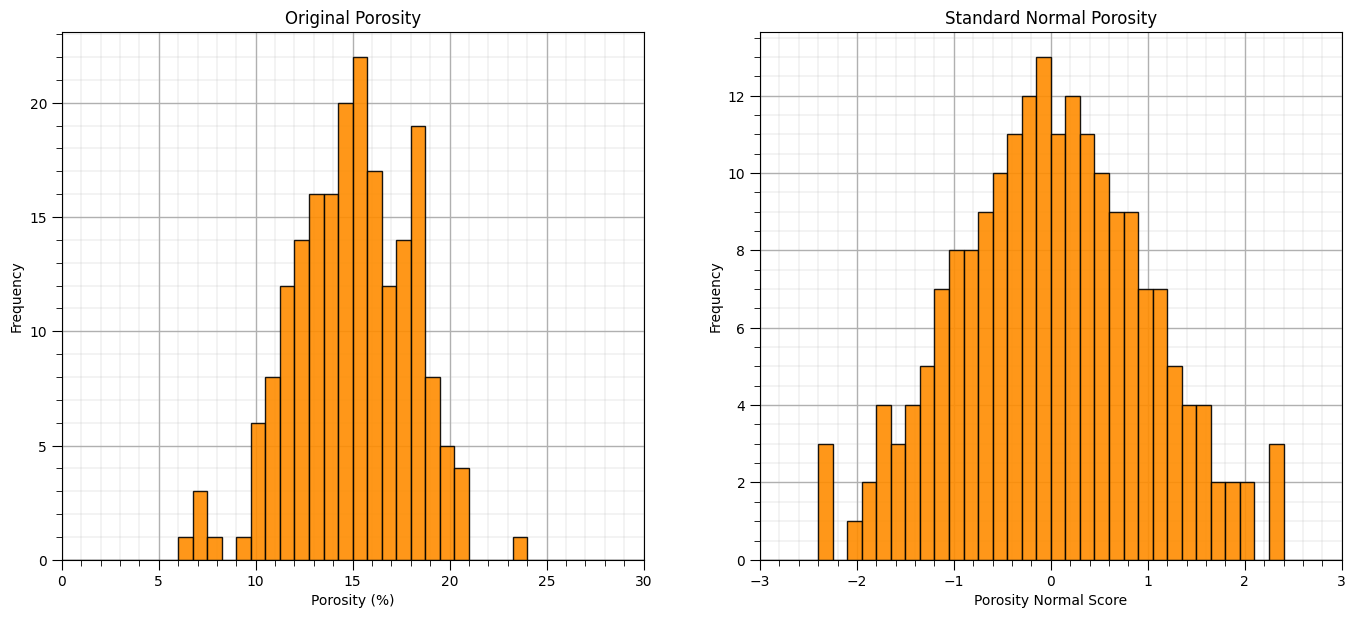

In [26]:
from sklearn.preprocessing import QuantileTransformer
nscore = QuantileTransformer(n_quantiles=100, random_state=73, output_distribution = 'normal') 
nsfeatures = nscore.fit_transform(df)                                                             # standardize all the values extracted from the DataFrame 
df_ns = pd.DataFrame()                                      # instantiate a new DataFrame
df_ns = pd.DataFrame(nsfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame
df_ns.head() 

plt.subplot(121)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
add_grid()

plt.subplot(122)
GSLIB.hist_st(df_ns['Por'].values,-3,3,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Normal Score',title='Standard Normal Porosity')
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Let's visualize the Gaussian transformed feature histograms.

* we should see a nice bell shape centered on 0.0 with a range of about -4 to 4.

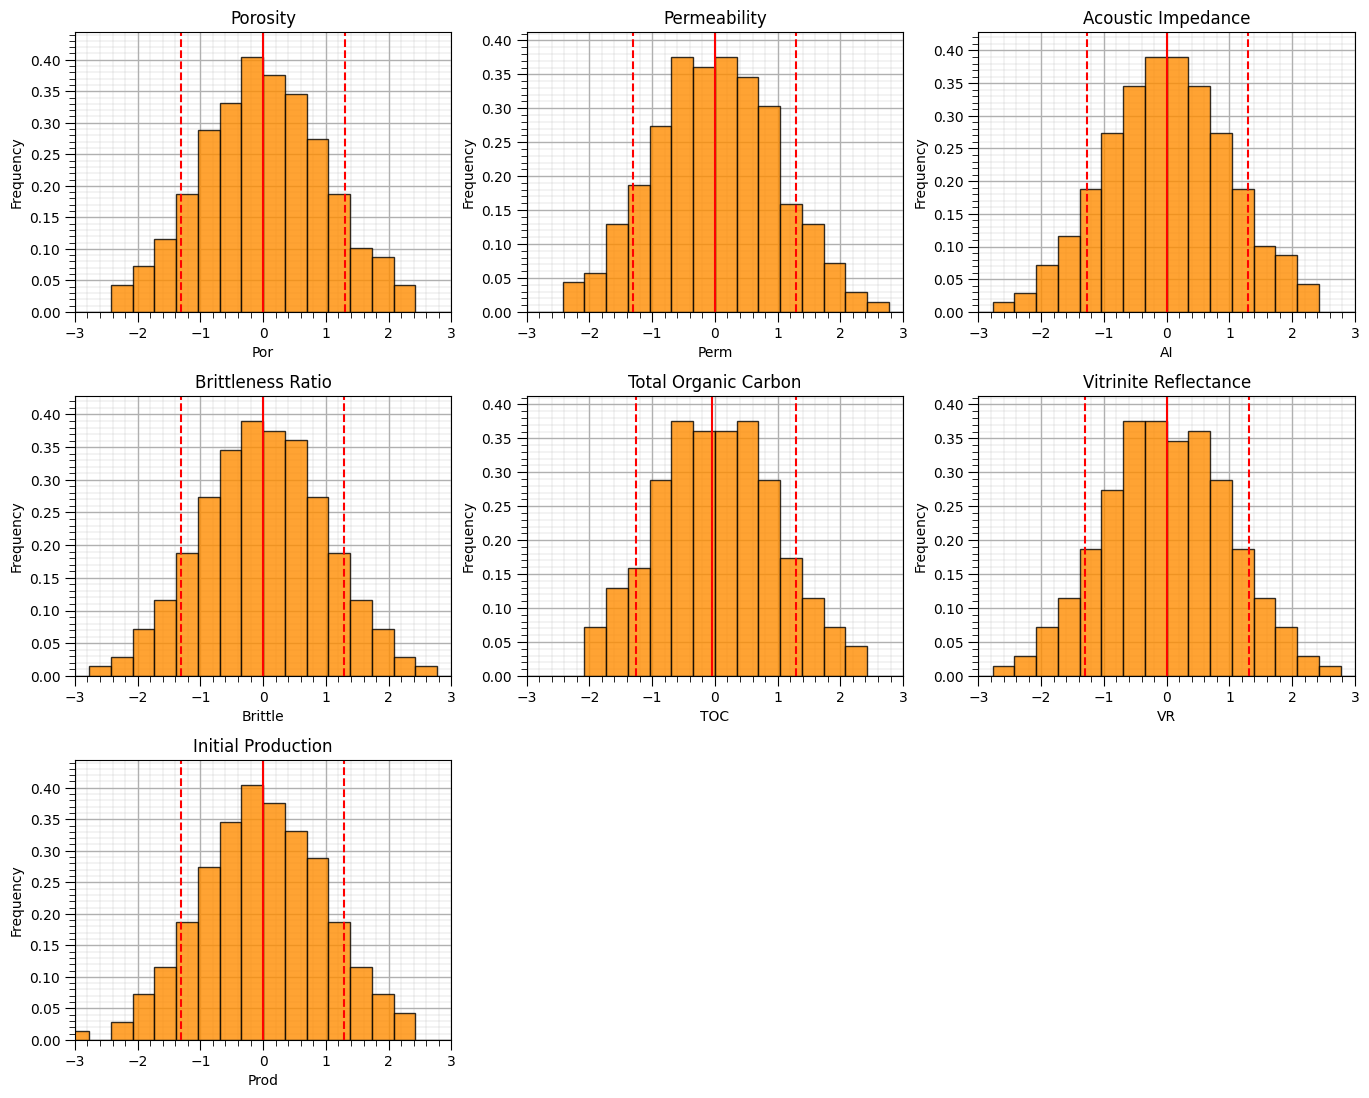

In [27]:
nbins = 30                                                    # number of histogram bins
for i, feature in enumerate(features):                        # plot histograms with central tendancy and P10 and P90 labelled
    plt.subplot(3,3,i+1)
    y,_,_ = plt.hist(x=df_ns[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True)
    histogram_bounds(values=df_ns[feature].values,weights=np.ones(len(df)),color='red')
    plt.xlabel(feature); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); plt.title(featuretitle[i]); add_grid() 
    plt.xlim([-3.0,3.0]) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.3); plt.show()

Once again, let's check out the reverse transform, from Gaussian back to the original features.

\begin{equation}
x = F_x^{-1}(G_y(y))
\end{equation}

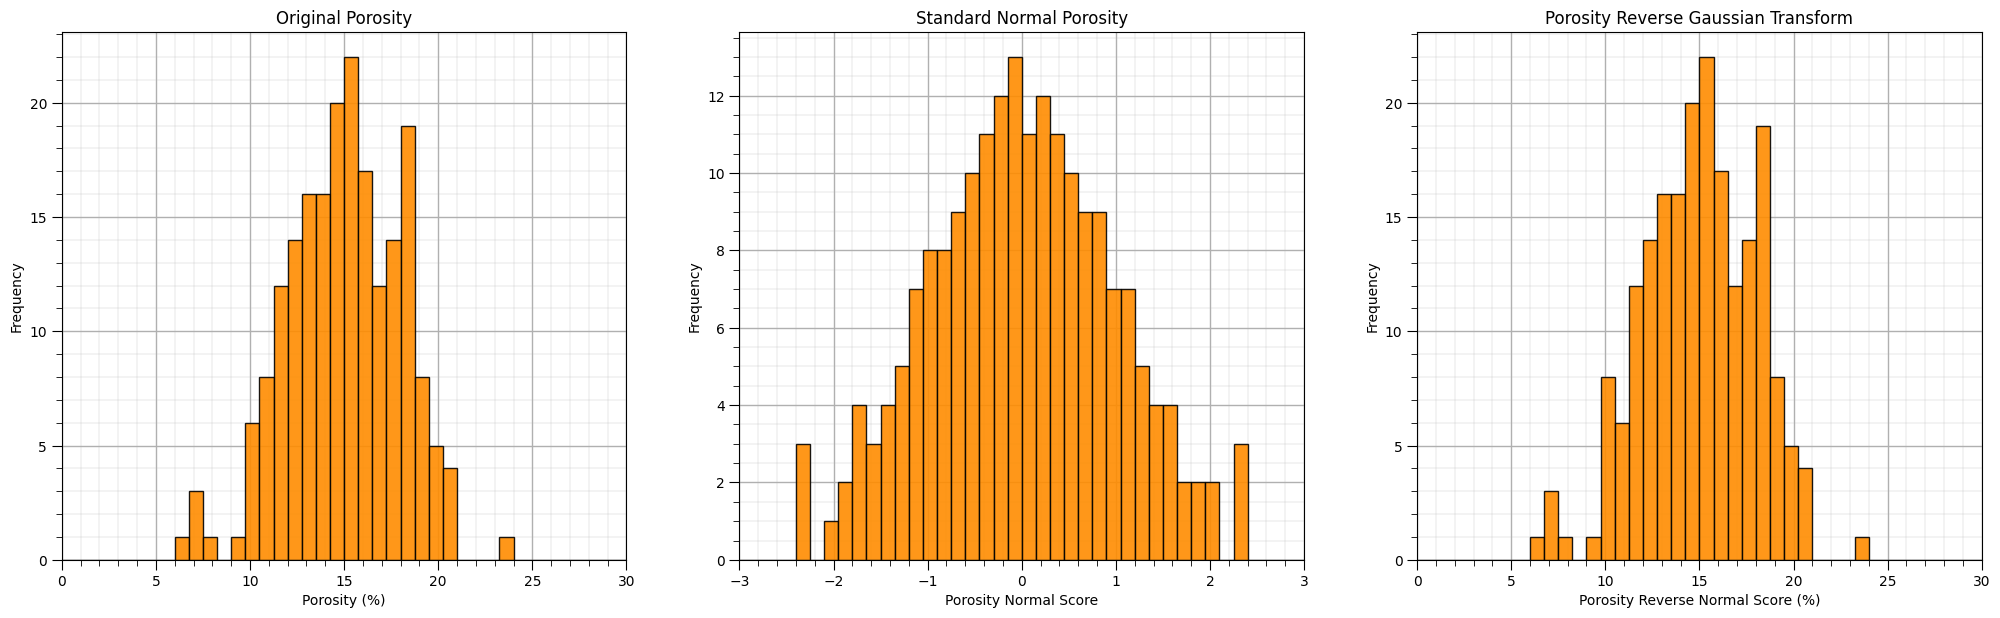

In [28]:
rfeatures = nscore.inverse_transform(df_ns.values)
df_reverse = pd.DataFrame()                                     # instantiate a new DataFrame
df_reverse = pd.DataFrame(rfeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame

plt.subplot(131)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
add_grid()

plt.subplot(132)
GSLIB.hist_st(df_ns['Por'].values,-3,3,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Normal Score',title='Standard Normal Porosity')
add_grid()

plt.subplot(133)
GSLIB.hist_st(df_reverse['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Reverse Normal Score (%)',title='Porosity Reverse Gaussian Transform')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)

#### Quantile / Uniform[0,1] Transform

We can also perform a uniform transform, this is known as the quantile transformation to the cummulative probability values.

* the cumulative probability values have a uniform distribution.

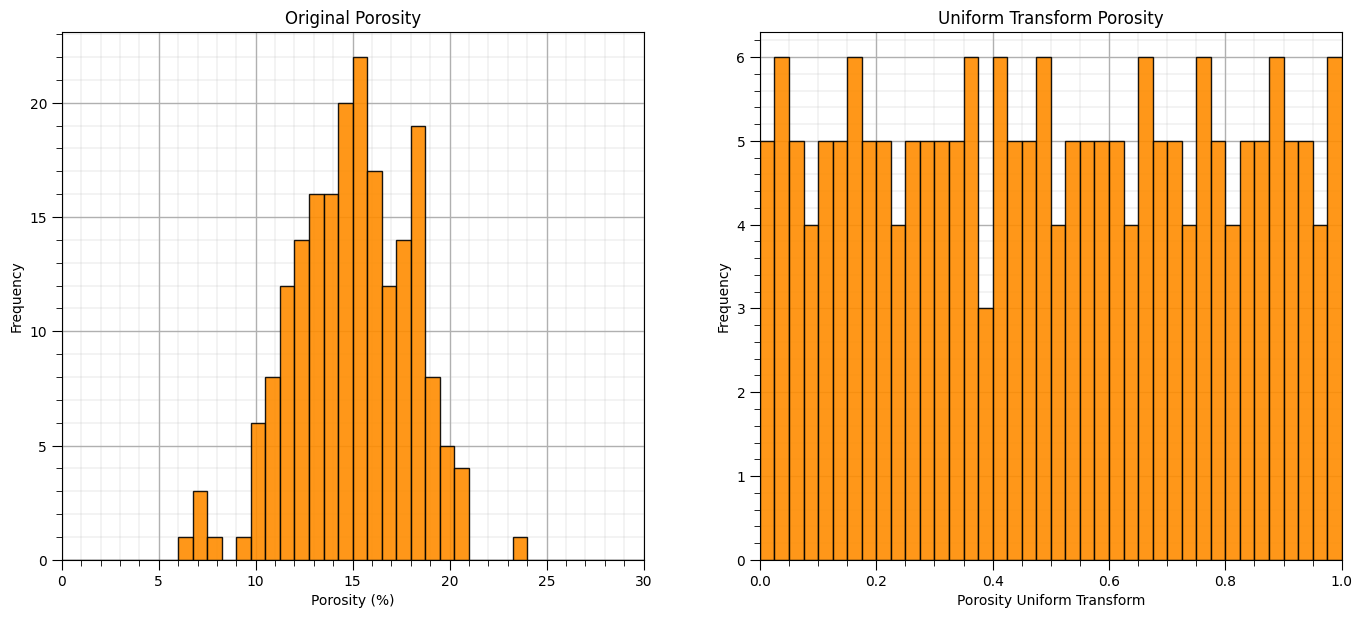

In [29]:
uniform = QuantileTransformer(n_quantiles=100, random_state=73, output_distribution = 'uniform') 
unifeatures = uniform.fit_transform(df)                                                             # standardize all the values extracted from the DataFrame 
df_uni = pd.DataFrame()                                      # instantiate a new DataFrame
df_uni = pd.DataFrame(unifeatures, index=df.index, columns=df.columns) # copy the standardized values into the new DataFrame

plt.subplot(121)
GSLIB.hist_st(df['Por'].values,0,30,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity (%)',title='Original Porosity')
add_grid()

plt.subplot(122)
GSLIB.hist_st(df_uni['Por'].values,0,1,log=False,cumul = False,bins=40,weights = None,xlabel='Porosity Uniform Transform',title='Uniform Transform Porosity')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)

Let's visualize the uniform transformed feature histograms.

* we should see a uniform frequencies (with some noise due to limited sampling) $\in [0,1]$.

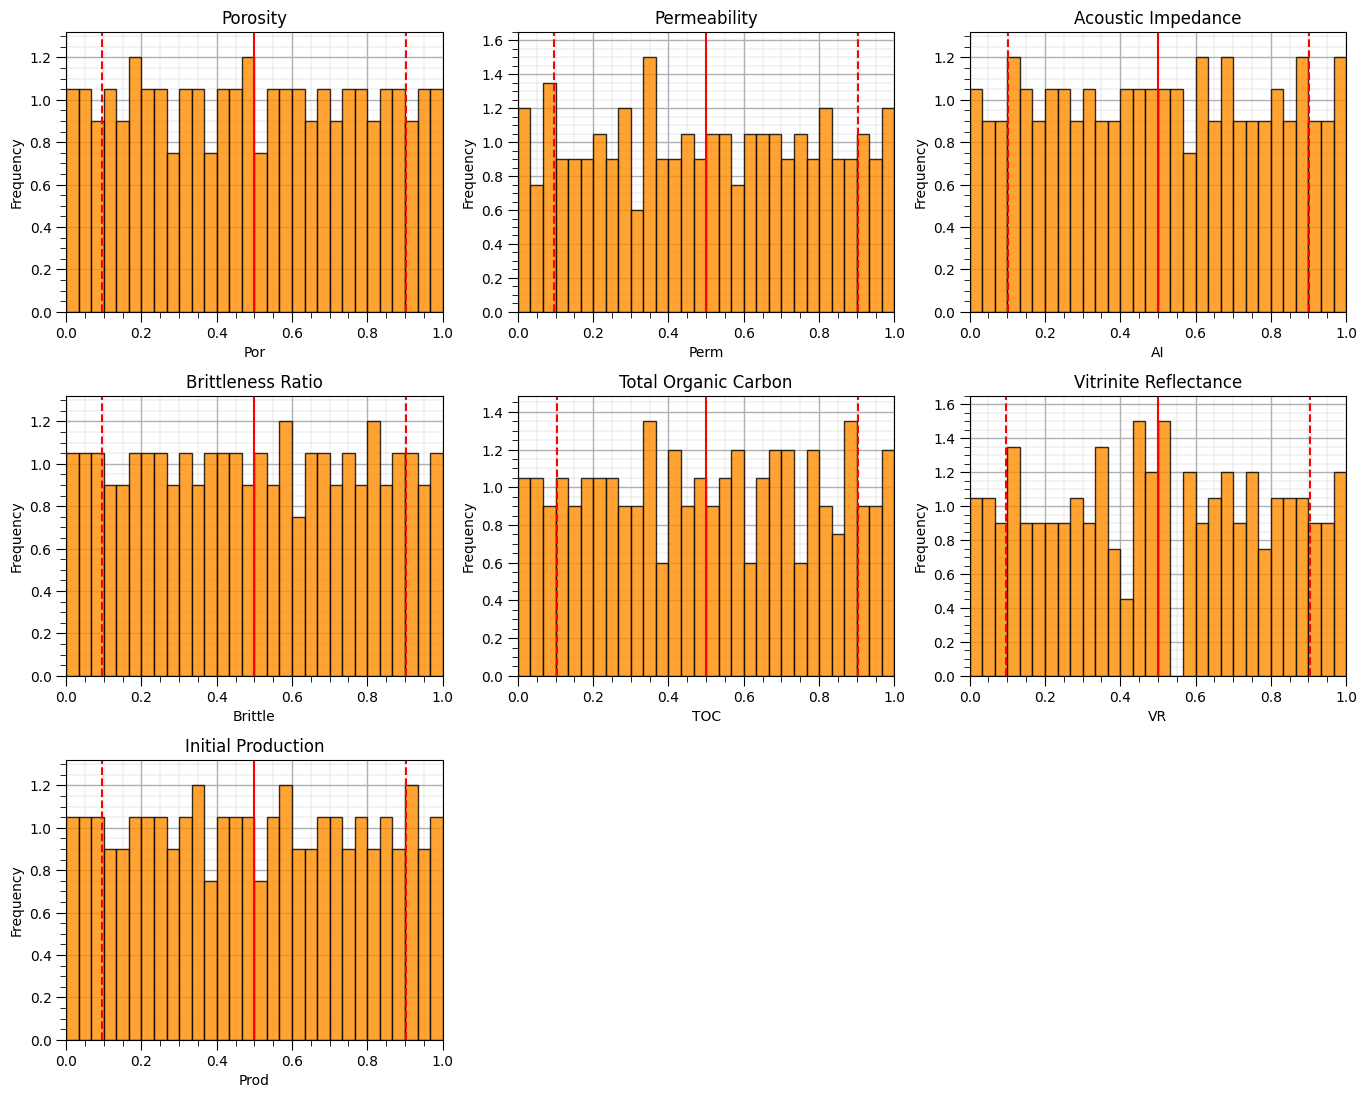

In [30]:
nbins = 30                                                    # number of histogram bins
for i, feature in enumerate(features):                        # plot histograms with central tendancy and P10 and P90 labelled
    plt.subplot(3,3,i+1)
    y,_,_ = plt.hist(x=df_uni[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True)
    histogram_bounds(values=df_uni[feature].values,weights=np.ones(len(df)),color='red')
    plt.xlabel(feature); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); plt.title(featuretitle[i]); add_grid() 
    plt.xlim([0.0,1.0]) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.3); plt.show()

We now have features with uniform distributions $[0,1]$.

#### Custom Feature Transforms

We can also create our own custom feature transformation.  We can specify our own transform within a scikit-learn preprocessing function

* this allows us to have a convenient method for forward and reverse transforms of our features as we have seen above

Let's demonstrate with the natural log for the foward transform and the exponential for the reverse transform.


$$
y = log(x)
$$

$$
x = exp(y)
$$

```python
custom_transformer = FunctionTransformer(func = np.log, inverse_func = np.exp)
```



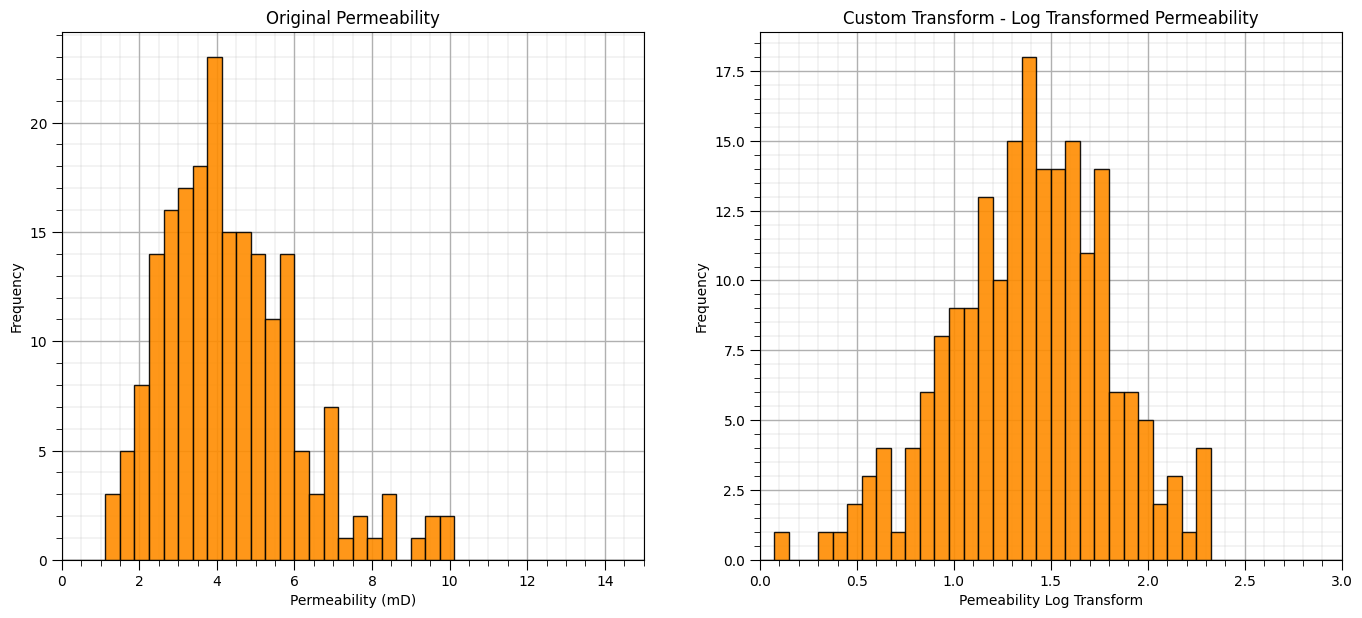

In [31]:
custom_transformer = FunctionTransformer(func = np.log, inverse_func = np.exp, check_inverse = True, validate=True)
custom_features = custom_transformer.fit_transform(df['Perm'].values.reshape(-1, 1))                                                             # standardize all the values extracted from the DataFrame 
df_custom = pd.DataFrame(custom_features, columns = ['LogPerm'])                 # instantiate a new DataFrame
df_custom.head() 

plt.subplot(121)
GSLIB.hist_st(df['Perm'].values,0,15,log=False,cumul = False,bins=40,weights = None,xlabel='Permeability (mD)',title='Original Permeability')
add_grid()

plt.subplot(122)
GSLIB.hist_st(df_custom['LogPerm'].values,0,3,log=False,cumul = False,bins=40,weights = None,xlabel='Pemeability Log Transform',title='Custom Transform - Log Transformed Permeability')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)

Let's demonstrate that our custom transform is reversible.

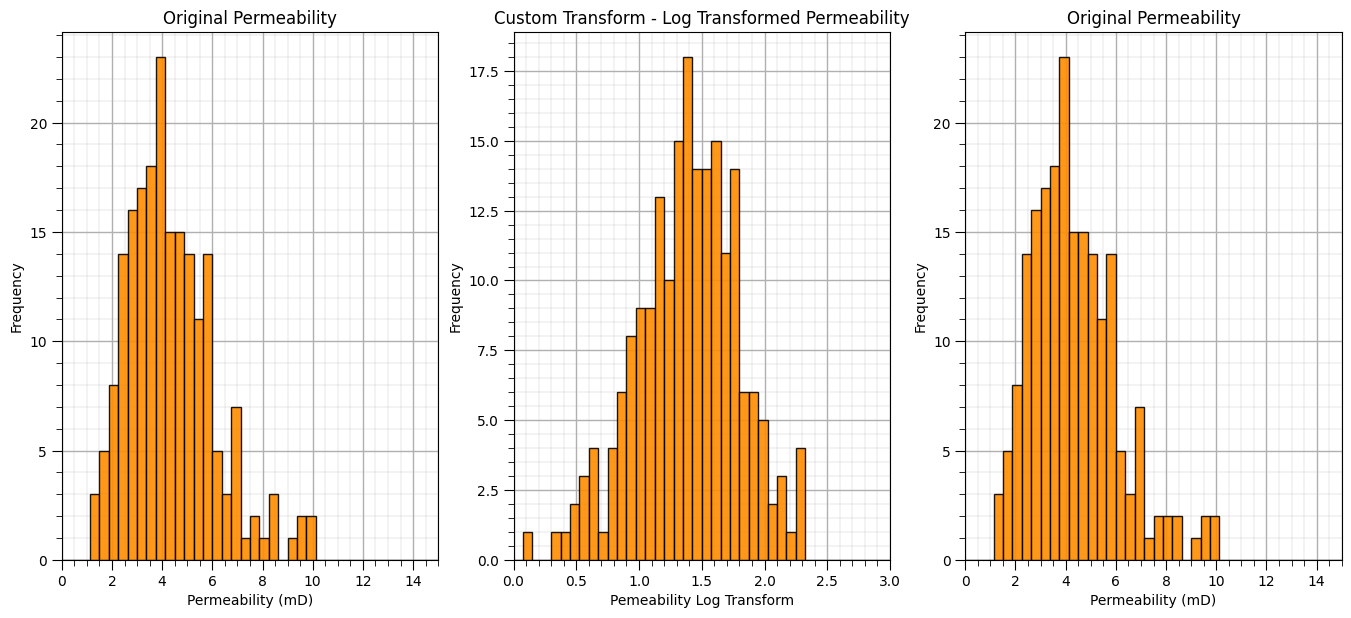

In [32]:
rfeatures = custom_transformer.inverse_transform(df_custom.values)
df_reverse = pd.DataFrame(rfeatures, index=df_custom.index, columns=['Perm']) # copy the standardized values into the new DataFrame

plt.subplot(131)
GSLIB.hist_st(df['Perm'].values,0,15,log=False,cumul = False,bins=40,weights = None,xlabel='Permeability (mD)',title='Original Permeability')
add_grid()

plt.subplot(132)
GSLIB.hist_st(df_custom['LogPerm'].values,0,3,log=False,cumul = False,bins=40,weights = None,xlabel='Pemeability Log Transform',title='Custom Transform - Log Transformed Permeability')
add_grid()

plt.subplot(133)
GSLIB.hist_st(df_reverse['Perm'].values,0,15,log=False,cumul = False,bins=40,weights = None,xlabel='Permeability (mD)',title='Original Permeability')
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Compare the back-transformed permeability values to the original dataset.  The reverse transform that we speficied with our custom transformation works!

#### Comments

I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig) | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  